In [1]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

output_folder = Path("../data/output_images/output_V6_TN")
output_folder.mkdir(exist_ok=True)

image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_1.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_3.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_4.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_5.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_6.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_7.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_8.png") # ซ้ำกับ 7
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_9.png") # จับตารางได้แต่พังตอน pt
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_10.png") # ลบเส้นตารางไม่หมดตรงรหัสวิชา
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_11.png") # ภาพใหญ่เกินไป
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_12.png") # ตารางไม่ตรง
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_13.png") # ติดลอยปั้มหมึก
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_14.png")
#image = Image.open("C:/Users/Impan/Documents/ocr-engine-python/data/test_images/transcript/technician/good/transcript_tn_f_15.png")

if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

new_size = (1660, 2347)  # ตัวอย่างขนาดใหม่
resized_pil = image.resize(new_size, Image.LANCZOS) # ปรับขนาดภาพด้วย LANCZOS filter

# แปลงภาพจาก PIL Image เป็น NumPy array (ในรูปแบบ RGB)
img_rgb = np.array(resized_pil)

# แปลงจาก RGB เป็น BGR เพื่อให้ใช้งานกับ OpenCV ได้
img_cv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

denoised = cv2.bilateralFilter(img_cv, d=9, sigmaColor=75, sigmaSpace=75) # จำกัด noise
gray_img = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)

binary_gaussian = cv2.adaptiveThreshold(
    gray_img, 
    maxValue=255, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=51, 
    C=21 #21
)

cv2.imwrite(f"{output_folder}/img_cv.png", img_cv)
cv2.imwrite(f"{output_folder}/denoised.png", denoised)
cv2.imwrite(f"{output_folder}/gray.png", gray_img)
cv2.imwrite(f"{output_folder}/binary_g.png", binary_gaussian)

True

In [2]:
def split_grade_table_and_students(binary_img, denoised):
    
    # แยกตาราง
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)
    areas = [stat[4] for stat in stats]  # ดึงค่า area
    sorted_areas = sorted(areas, reverse=True)  # เรียงลำดับจากมากไปน้อย
    second_max_area = sorted_areas[1]  # ค่าอันดับ 2
    second_max_area_index = areas.index(second_max_area)  # หาตำแหน่งในลิสต์เดิม
    table_position = stats[second_max_area_index]
    x, y, w, h, area = table_position
    table_img = binary_img[y:y+h, x:x+w]
    table_original_img = denoised[y:y+h, x:x+w]

    # ข้อมูลนักเรียน
    #x_start = int((x+w) * 0.40) # ความกว้าง 40% ของตาราง
    x_end = int((x+w) * 0.85) # ความกว้าง 85% ของตาราง
    x_split_half = int((x+w) * 0.38) # ความกว้าง 38% ของตาราง

    student_info_img = binary_img[:y, :x_end]
    student_info_fh_img = binary_img[:y, :x_split_half] # ครึ่งแรก
    student_info_sh_img = binary_img[:y, x_split_half:x_end] # ครึ่งหลัง

    return table_img, student_info_img, student_info_fh_img, student_info_sh_img, table_original_img

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        #print(area)
        if area > 1000:
            #print("มา")
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area

    return biggest

def persective_transformation(table_binary_img, table_original_img):

    # ค้นหาคอนทัวร์
    contours, hierarchy = cv2.findContours(table_binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #contours, hierarchy = cv2.findContours(table_binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    # ค้นหาสี่เหลี่ยมที่ใหญ่ที่สุด
    biggest = biggest_contour(contours)

    points = biggest.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")

    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]

    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]

    (top_left, top_right, bottom_right, bottom_left) = input_points

    # Euclidean Distance Formula
    bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    rigth_height = np.sqrt(((top_left[0] - bottom_right[0]) ** 2) + ((top_left[1] - bottom_right[1]) ** 2))
    left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

    # Output image size
    #max_width = max(int(bottom_width), int(top_width))
    expand_width = round(max(int(bottom_width), int(top_width)) * 0.4)
    max_width = max(int(bottom_width), int(top_width)) + expand_width
    max_height = max(int(rigth_height), int(left_height))

    # Desird points values in the output image
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

    # Perspective transformaxtion
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_out = cv2.warpPerspective(table_binary_img.copy(), matrix, (max_width, max_height))
    img_original_out = cv2.warpPerspective(table_original_img.copy(), matrix, (max_width, max_height))

    return img_out, img_original_out

def hough_line_transform(binary_image, table_original_persective_img, grid_img):

    # 1) ใช้ HoughLinesP ตรวจจับเส้น
    #    - พารามิเตอร์ที่สำคัญ: threshold, minLineLength, maxLineGap
    lines = cv2.HoughLinesP(
        binary_image,
        rho=1,
        theta=np.pi/180,
        threshold=100,      # ต้องปรับจูน
        minLineLength=700,  # ต้องปรับจูน
        maxLineGap=10     # ต้องปรับจูน
    )

    # 2) สร้าง mask (เป็นภาพดำล้วน ขนาดเท่ากับต้นฉบับ)
    line_mask = np.zeros_like(binary_image)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # วาดเส้นสีขาวลงใน mask (ปรับ thickness ตามความหนาเส้นในภาพ)
            cv2.line(line_mask, (x1, y1), (x2, y2), 255, 2)

    # 4) เราจะเอา mask นี้มาช่วยลบเส้นในภาพ
    #    วิธีง่าย ๆ คือการเอา thresh ที่เป็น binary_inv มาลบด้วย mask (bitwise)
    #    หรืออาจใช้เทคนิค inpaint บนภาพสี

    # วิธีที่ 4.1: ลบตรง ๆ จาก thresh ก่อน (ซึ่งเป็น Binary แล้ว)
    table_without_lines = cv2.bitwise_and(binary_image, cv2.bitwise_not(line_mask))
    table_without_lines_2 = cv2.bitwise_and(table_without_lines, cv2.bitwise_not(grid_img))


    # หรือ วิธีที่ 4.2: ลอง inpaint บนภาพจริงสี (img)
    #    โดยปกติ inpaint จะต้องการ mask สีขาว บริเวณที่ต้องการซ่อมแซม
    #    ซึ่ง line_mask ของเราพอดีอยู่แล้ว
    inpainted = cv2.inpaint(table_original_persective_img, line_mask, 3, cv2.INPAINT_TELEA)

    #kernel = np.ones((20, 15), np.uint8)
    #final_dilate = cv2.dilate(image_without_lines, kernel, iterations=1)


    # เนื่องจาก thresh เป็น invert (พื้นดำ ตัวหนังสือขาว)
    # ถ้าอยากกลับด้านให้พื้นขาว ตัวหนังสือดำก็ทำ bitwise_not อีกที
    #final = cv2.bitwise_not(image_without_lines)
    cv2.imwrite(f"{output_folder}/line_mask.png", line_mask)
    cv2.imwrite(f"{output_folder}/image_without_lines.png", table_without_lines)
    cv2.imwrite(f"{output_folder}/image_without_lines_2.png", table_without_lines_2)
    #cv2.imwrite(f"{output_folder}/final_dilate.png", final_dilate)
    cv2.imwrite(f"{output_folder}/inpainted.png", inpainted)

    return line_mask, table_without_lines, table_without_lines_2

def cells_detect(grid_lines):
    # ขั้นตอนที่ 1: Invert ภาพ
    inverted = cv2.bitwise_not(grid_lines) # (เพื่อให้พื้นที่ดำ (ช่องตาราง) กลายเป็นสีขาว, ส่วนเส้นขาวจะเป็นสีดำ)

    # ขั้นตอนที่ 2: Erode พื้นที่ขาวเล็กน้อย เพื่อลดการติดเส้น
    kernel = np.ones((3, 3), np.uint8) # สร้าง kernel เล็ก ๆ เพื่อ erode
    eroded = cv2.erode(inverted, kernel, iterations=0)

    #cv2.imwrite(f"{output_folder}/eroded.png", eroded)

    # ขั้นตอนที่ 3: Find Contours (หาพื้นที่สีขาว ซึ่งเป็นรูปทรงของช่องตาราง)
    #contours, hierarchy = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = filter(lambda c: cv2.boundingRect(c)[2] > 40, contours)  # กรอง w > 10
    contours = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[3], reverse=True)[:10] # เรียงลำดับ contours ตามค่า h (ความสูง) จากมากไปน้อย
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0], reverse=False)  # เรียงลำดับ contours ตามค่า x จากน้อยไปมาก
 
    # ขั้นตอนที่ 4: วนลูปดูผลลัพธ์ของ Contours แต่ละอัน

    output = cv2.cvtColor(grid_lines.copy(), cv2.COLOR_GRAY2BGR)  # ไว้สำหรับวาดกรอบ

    cell_contours = []

    for i, cnt in enumerate(contours):
        # หา bounding box ของ contour
        x, y, w, h = cv2.boundingRect(cnt)
        area = int(cv2.contourArea(cnt))
        cell_contours.append([x, y, w, h, area])

        # วาดสี่เหลี่ยมครอบลงบน output เพื่อดู
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
        print(f"Contour #{i}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")

    cv2.imwrite(f"{output_folder}/Contours.png", output)

    return cell_contours

def create_grid_image(table_img,
                      col_percentages=[8, 40, 43, 46.33, 50, 58, 90, 93, 96.33, 100],
                      #col_percentages=[8, 39, 43, 46.33, 50, 58, 89, 93, 96.33, 100],
                      row_percentages=[9.22, 100],
                      grid_color=(255, 255, 255),
                      vertical_line_thickness_percent=0.005,   # 0.33% ของความกว้างภาพสำหรับเส้นแนวตั้ง
                      horizontal_line_thickness_percent=0.008, # 0.33% ของความกว้างภาพสำหรับเส้นแนวนอน
                      bg_color=(0, 0, 0),
                      return_binary=True,
                      threshold_val=127):
    
    """
    สร้างภาพตารางที่มีขนาด width x height โดยแบ่งคอลัมน์และแถวตามเปอร์เซ็นต์ที่กำหนด
    ความหนาของเส้นจะถูกคำนวณเป็นเปอร์เซ็นต์ของความกว้างของภาพ
    ถ้า return_binary=True จะทำการแปลงภาพเป็น binary (ขาวดำ) โดยใช้ threshold ที่กำหนด

    :param width: ความกว้างของภาพ (พิกเซล)
    :param height: ความสูงของภาพ (พิกเซล)
    :param col_percentages: รายการเปอร์เซ็นต์สำหรับขอบขวาของแต่ละคอลัมน์ (เรียงจากน้อยไปมาก; คอลัมน์สุดท้าย = 100%)
    :param row_percentages: รายการเปอร์เซ็นต์สำหรับขอบล่างของแต่ละแถว (เรียงจากน้อยไปมาก; แถวสุดท้าย = 100%)
    :param grid_color: สีของเส้นตารางในรูปแบบ (B, G, R)
    :param line_thickness_percent: ความหนาของเส้นในรูปแบบเปอร์เซ็นต์ของความกว้างภาพ
    :param bg_color: สีพื้นหลังของภาพ
    :param return_binary: ถ้า True จะคืนภาพในรูปแบบ binary (หลัง threshold) มิฉะนั้นคืนค่าเป็น BGR image
    :param threshold_val: ค่าที่ใช้ threshold เมื่อแปลงเป็นภาพ binary
    :return: ภาพตารางในรูปแบบ binary (ถ้า return_binary=True) หรือ BGR image (ถ้า False)
    """

    height, width, = table_img.shape  # ได้ค่า (สูง, กว้าง)

    image = np.full((height, width, 3), bg_color, dtype=np.uint8)
    
    # คำนวณความหนาของเส้นสำหรับแต่ละแนว (อย่างน้อย 1 พิกเซล)
    vertical_thickness = max(1, int(width * vertical_line_thickness_percent))
    horizontal_thickness = max(1, int(width * horizontal_line_thickness_percent))
    
    # คำนวณตำแหน่งเส้นแนวตั้ง (x_positions)
    col_fracs = [p / 100.0 for p in col_percentages]
    x_positions = [0] + [int(width * p) for p in col_fracs]
    
    # คำนวณตำแหน่งเส้นแนวนอน (y_positions)
    row_fracs = [p / 100.0 for p in row_percentages]
    y_positions = [0] + [int(height * p) for p in row_fracs]
    
    # วาดเส้นตารางแนวตั้งโดยใช้ความหนาที่คำนวณสำหรับแนวตั้ง
    for x in x_positions:
        cv2.line(image, (x, 0), (x, height), grid_color, vertical_thickness)
    
    # วาดเส้นตารางแนวนอนโดยใช้ความหนาที่คำนวณสำหรับแนวนอน
    for y in y_positions:
        cv2.line(image, (0, y), (width, y), grid_color, horizontal_thickness)
    
    # แปลงภาพเป็น binary หากต้องการ
    if return_binary:
        # แปลงเป็น grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # ใช้ threshold เพื่อแปลงเป็นภาพ binary
        _, binary_image = cv2.threshold(gray, threshold_val, 255, cv2.THRESH_BINARY)
        return binary_image
    else:
        return image

table_img, student_info_img, student_info_fh_img, student_info_sh_img, table_original_img = split_grade_table_and_students(binary_gaussian, denoised)
table_persective_img, table_original_persective_img = persective_transformation(binary_gaussian, denoised)
grid_img = create_grid_image(table_persective_img)
line_mask, table_without_lines, table_without_lines_2 = hough_line_transform(table_persective_img, table_original_persective_img, grid_img)

cell_contours = cells_detect(grid_img)

cv2.imwrite(f"{output_folder}/table_img.png", table_img)
cv2.imwrite(f"{output_folder}/student_info_img.png", student_info_img)
cv2.imwrite(f"{output_folder}/table_original_img.png", table_original_img)
cv2.imwrite(f"{output_folder}/table_persective_img.png", table_persective_img)
cv2.imwrite(f"{output_folder}/table_original_persective_img.png", table_original_persective_img)
cv2.imwrite(f"{output_folder}/student_info_fh_img.png", student_info_fh_img)
cv2.imwrite(f"{output_folder}/student_info_sh_img.png", student_info_sh_img)
cv2.imwrite(f"{output_folder}/grid_img.png", grid_img)

Contour #0: bounding box = (x=6, y=192, w=156, h=1788, area=276985)
Contour #1: bounding box = (x=173, y=192, w=661, h=1788, area=1179420)
Contour #2: bounding box = (x=845, y=192, w=52, h=1788, area=91137)
Contour #3: bounding box = (x=908, y=192, w=59, h=1788, area=103646)
Contour #4: bounding box = (x=978, y=192, w=66, h=1788, area=116155)
Contour #5: bounding box = (x=1055, y=192, w=157, h=1788, area=278772)
Contour #6: bounding box = (x=1223, y=192, w=661, h=1788, area=1179420)
Contour #7: bounding box = (x=1895, y=192, w=52, h=1788, area=91137)
Contour #8: bounding box = (x=1958, y=192, w=58, h=1788, area=101859)
Contour #9: bounding box = (x=2027, y=192, w=67, h=1788, area=117942)


True

# แบ่งส่วนตาราง

In [3]:
def crop_image(cell_contours, table_without_lines):
    cell_images = []
    for idx, cell_position in enumerate(cell_contours):
        x, y, w, h, area = cell_position
        crop_img = table_without_lines[y:y+h, x:x+w]
        cell_images.append(crop_img)
        cv2.imwrite(f"{output_folder}/cell_images/crop_img_{idx}.png", crop_img)
        #print(f"Contour #{idx}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")

    return cell_images
        
cell_images = crop_image(cell_contours, table_without_lines_2)

cell_subject_code_img = cell_images[0]
cell_subject_name_img = cell_images[1]
cell_credit_img = cell_images[2]
cell_academic_results_img = cell_images[3]
cell_subject_code_img_2 = cell_images[5]
cell_subject_name_img_2 = cell_images[6]
cell_credit_img_2 = cell_images[7]
cell_academic_results_img_2 = cell_images[8]

In [4]:
def detect_text_group_in_cell(cell_img, mode=0, calculate_line_stats=None):
    text_group_images = []

    kernel_open = np.ones((4, 4), np.uint8)
    #kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    remove_noise = cv2.morphologyEx(cell_img, cv2.MORPH_OPEN, kernel_open, iterations=1)

    #cv2.imwrite(f"{output_folder}/cell_images/remove_noise.jpg", remove_noise)

    kernel = np.ones((3, 13), np.uint8)
    group_text_img = cv2.dilate(remove_noise, kernel, iterations=2)
    rgb_image = cv2.cvtColor(cell_img.copy(), cv2.COLOR_GRAY2RGB)

    #plt.figure(figsize=(15, 15))
    #plt.imshow(group_text, cmap="gray")

    if(mode == 1):
        # ใช้ Connected Component Analysis
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(group_text_img, connectivity=8)

        text_stats = stats[1:]
        sorted_indices = np.argsort(text_stats[:, 1])  # จัดเรียงตามค่า y (คอลัมน์ที่ 1)
        sorted_stats = text_stats[sorted_indices]

        # ใช้ Boolean Indexing เพื่อเอา noise ออก 
        sorted_stats = sorted_stats[sorted_stats[:, 4] >= 2000]
        calculate_line_stats = []

        for idx_stat, stat in enumerate(sorted_stats):
            x, y, w, h, area = stat
            #print(f"CCA #{idx_stat}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            if idx_stat == (len(sorted_stats)-1):
                #print("เข้าเงื่อนลำดัยสุดท้าย",idx_stat)
                x, y, w, h, area = stat
                new_y = round(y-(h/2))
                new_h = round(h+(h*0.8))
                calculate_line_stats.append([x, new_y, w, new_h, area])
            else:
                current_stat = stat
                next_stat = sorted_stats[idx_stat+1]

                distance = next_stat[1] - current_stat[1]
                line_spacing = distance/current_stat[3]

                if line_spacing > 3 and line_spacing <= 5: # เป็นชื่อวิชาที่มีความยาวมากกว่า 1 บรรทัด
                    #print("เข้าเงื่อนไข มากกว่า 1 บรรทัด")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+(h*2.5))
                    calculate_line_stats.append([x, new_y, w, new_h, area])

                elif line_spacing > 6: # เป็นช่องว่างที่ไม่มีวิชา
                    #print("เข้าเงื่อนไข เป็นช่องว่างที่ไม่มีวิชา")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+h)
                    calculate_line_stats.append([x, new_y, w, new_h, area])
                
                else: # เป็นชื่อวิชาที่มีความยาวแค่ว่า 1 บรรทัด
                    #print("เข้าเงื่อนไข 1 บรรทัด")
                    x, y, w, h, area = current_stat
                    new_y = round(y-(h/2))
                    new_h = round(h+(h*0.8))
                    calculate_line_stats.append([x, new_y, w, new_h, area])

        calculate_line_stats = np.array(calculate_line_stats) 

            #print(f"CCA #{idx_stat}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            #cv2.rectangle(rgb_image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #cv2.imwrite(f"{output_folder}/cell_images/cca.jpg", rgb_image)

    text_stats = sorted_stats if mode == 1 else calculate_line_stats

    
    for idx, stats in enumerate(text_stats): # เก็บภาพกลุม
        x, y, w, h, area = stats
   
        if mode == 1:
            cca_img = cell_img[y:y+h, x:x+w]
        if mode == 2:
            #print(f"stats #{idx}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={area})")
            if idx == 0: # ดักบัค crop รูปเกินขอบเขต
                cca_img = cell_img[y+5:y+h, :]
            elif idx == (len(text_stats)-1):
                cca_img = cell_img[y:y+h-5, :]
            else:
                cca_img = cell_img[y:y+h, :]
        text_group_images.append(cca_img)

        # หาขนาดของภาพ (ความกว้างและความสูง)
        image_height, image_width, _ = rgb_image.shape  # ได้ค่า (สูง, กว้าง, ช่องสี)
        cv2.rectangle(rgb_image, (x, y), (image_width, y + h), (0, 255, 0), 1)

    if mode == 1:
        return text_group_images, calculate_line_stats, rgb_image
    else:
        return text_group_images, rgb_image

# ตารางครึ่งแรก
text_subject_code_images, calculate_line_stats_1, subject_code_img = detect_text_group_in_cell(cell_subject_code_img, 1)
text_subject_name_images, subject_name_img = detect_text_group_in_cell(cell_subject_name_img, 2, calculate_line_stats_1)
text_credit_images, credit_img = detect_text_group_in_cell(cell_credit_img, 2, calculate_line_stats_1)
text_academic_results_images, academic_results_img = detect_text_group_in_cell(cell_academic_results_img, 2, calculate_line_stats_1)

# ตารางครึ่งหลัง
text_subject_code_images_2, calculate_line_stats_2, subject_code_img_2 = detect_text_group_in_cell(cell_subject_code_img_2, 1)
text_subject_name_images_2, subject_name_img_2 = detect_text_group_in_cell(cell_subject_name_img_2, 2, calculate_line_stats_2)
text_credit_images_2, credit_img_2 = detect_text_group_in_cell(cell_credit_img_2, 2, calculate_line_stats_2)
text_academic_results_images_2, academic_results_img_2 = detect_text_group_in_cell(cell_academic_results_img_2, 2, calculate_line_stats_2)

cv2.imwrite(f"{output_folder}/cell_images/cca_subject_code_img.jpg", subject_code_img)
cv2.imwrite(f"{output_folder}/cell_images/cca_subject_name_img.jpg", subject_name_img)
cv2.imwrite(f"{output_folder}/cell_images/cca_credit_img.jpg", credit_img)
cv2.imwrite(f"{output_folder}/cell_images/cca_academic_results_img.jpg", academic_results_img)
cv2.imwrite(f"{output_folder}/cell_images/cca_subject_code_img_2.jpg", subject_code_img_2)
cv2.imwrite(f"{output_folder}/cell_images/cca_subject_name_img_2.jpg", subject_name_img_2)
cv2.imwrite(f"{output_folder}/cell_images/cca_credit_img_2.jpg", credit_img_2)
cv2.imwrite(f"{output_folder}/cell_images/cca_academic_results_img_2.jpg", academic_results_img_2)
#cv2.imwrite(f"{output_folder}/cell_images/cca_text_subject_name_images.jpg", subject_name_img)


True

In [ ]:
for idx, img in enumerate(text_subject_code_images):
    print(idx)
    plt.figure(figsize=(15, 15))
    plt.imshow(img, cmap="gray")

### จับข้อความย่อยในกลุ่มข้อความของ cell ตาราง

In [5]:
from numpy import append

def detect_sub_text_in_group(binary_image):

    text_group = []
    for idx, img in enumerate(binary_image):
        #print(idx+1)

        #plt.figure(figsize=(5,5))
        #plt.imshow(img, cmap="gray")
        #plt.title(f"binary_image")
        #plt.show()

        sub_text_images = []

        kernel_open = np.ones((3, 3), np.uint8)
        remove_noise = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open, iterations=1)

        #plt.figure(figsize=(5,5))
        #plt.imshow(remove_noise, cmap="gray")
        #plt.title(f"remove_noise")
        #plt.show()

        # เช็คว่าภาพเป็นสีดำทั้งหมดหรือไม่
        if not np.any(remove_noise):  # ถ้าค่าพิกเซลทั้งหมดเป็น 0 (ดำสนิท)
            print("ภาพเป็นสีดำทั้งหมด")
            sub_text_images.append(remove_noise)
            #return sub_text_images 
        
        else:
            kernel = np.ones((6, 6), np.uint8)
            dummy_image = cv2.dilate(remove_noise, kernel, iterations=2)

            #plt.figure(figsize=(5,5))
            #plt.imshow(dummy_image, cmap="gray")
            #plt.title(f"dummy_image")
            #plt.show()

            # ใช้ Connected Component Analysis
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)
            char_stats = stats[1:] # ข้าม Background (index 0)
            sorted_indices = np.argsort(char_stats[:, 0]) # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
            sorted_stats = char_stats[sorted_indices]

            # ใช้ Boolean Indexing เพื่อเอา noise ออก 
            sorted_stats = sorted_stats[sorted_stats[:, 4] >= 200]

            for idx, stats in enumerate(sorted_stats):
                #x, y, w, h, area = stats[i]
                x, y, w, h, area = stats

                cca_img = img[y:y+h, x:x+w]
                sub_text_images.append(cca_img)

        text_group.append(sub_text_images)

    return text_group
    
text_group_subject_code = detect_sub_text_in_group(text_subject_code_images)
text_group_subject_name = detect_sub_text_in_group(text_subject_name_images)
text_group_credit = detect_sub_text_in_group(text_credit_images)
text_group_academic_results = detect_sub_text_in_group(text_academic_results_images)

text_group_subject_code_2 = detect_sub_text_in_group(text_subject_code_images_2)
text_group_subject_name_2 = detect_sub_text_in_group(text_subject_name_images_2)
text_group_credit_2 = detect_sub_text_in_group(text_credit_images_2)
text_group_academic_results_2 = detect_sub_text_in_group(text_academic_results_images_2)



ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด
ภาพเป็นสีดำทั้งหมด


In [ ]:
# ทดสอบดูรูป
for idx_g, text_group in enumerate(text_group_subject_code):
    print(f"text {idx_g+1}")
    for idx_s, sub_text in enumerate(text_group):
        plt.figure(figsize=(4,4))
        plt.imshow(sub_text, cmap="gray")
        plt.title(f"sub text {idx_s+1}")
        plt.show()

## จับตัวอักษร

ภาพว่างเปล่า


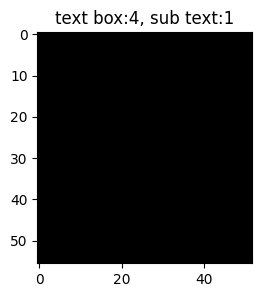

ภาพว่างเปล่า


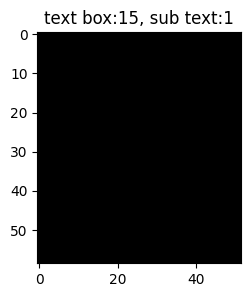

In [75]:
from turtle import width

def scale_contour(contour, scale_factor=1.1):
    # คำนวณ centroid ของ contour
    M = cv2.moments(contour)
    if M["m00"] == 0:
        return contour
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    
    # แปลง contour เป็น float32 เพื่อคำนวณ
    scaled_contour = contour.astype(np.float32)
    for i in range(scaled_contour.shape[0]):
        x, y = scaled_contour[i, 0]
        # ปรับขนาดแต่ละจุดโดยคำนวณจาก centroid
        scaled_x = cx + (x - cx) * scale_factor
        scaled_y = cy + (y - cy) * scale_factor
        scaled_contour[i, 0] = [scaled_x, scaled_y]
    
    return scaled_contour.astype(np.int32)

def percentage_difference(value1, value2):
    return abs(value1 - value2) / value1 * 100

def get_centroid(contour):
    # คำนวณ moments ของ contour
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = M["m10"] / M["m00"]
        cy = M["m01"] / M["m00"]
    else:
        cx, cy = 0, 0
    return (cx, cy)

def detect_one_level_of_char(text_group):
    debug = False
    text_group_char = []
    for idx_g, text_g in enumerate(text_group):

        sub_text_char = []
        for idx_s, sub_text in enumerate(text_g):

            if not np.any(sub_text): # เช็คว่าเป็นภาพว่างรึเปล่า

                print("ภาพว่างเปล่า")
                sub_text_char.append([sub_text])
                
                plt.figure(figsize=(3, 3))
                plt.imshow(sub_text, cmap="gray")
                plt.title(f"text box:{idx_g+1}, sub text:{idx_s+1}")
                plt.show()
                continue

            if debug == True:
                plt.figure(figsize=(3, 3))
                plt.imshow(sub_text, cmap="gray")
                plt.title(f"text box:{idx_g+1}, sub text:{idx_s+1}")
                plt.show()
            
            
            #skeleton = cv2.ximgproc.thinning(sub_text, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
            skeleton_guohall = cv2.ximgproc.thinning(sub_text, thinningType=cv2.ximgproc.THINNING_GUOHALL)

            if debug == True:
                plt.figure(figsize=(3, 3))
                plt.imshow(skeleton_guohall, cmap="gray")
                plt.title(f"skeleton, text box:{idx_g+1}, sub text:{idx_s+1}")
                plt.show()
            
            
            #kernel_open = np.ones((2, 2), np.uint8)
            kernel_dummy = np.ones((2, 2), np.uint8)
            #opening = cv2.morphologyEx(skeleton, cv2.MORPH_OPEN, kernel=kernel_open, iterations=2)
            #closing = cv2.morphologyEx(skeleton, cv2.MORPH_CLOSE, kernel=kernel_open, iterations=2)
            dummy_image = cv2.dilate(skeleton_guohall, kernel_dummy, iterations=1)

            if debug == True:
                plt.figure(figsize=(3, 3))
                plt.imshow(dummy_image, cmap="gray")
                plt.title(f"dummy_image, text box:{idx_g+1}, sub text:{idx_s+1}")
                plt.show()
            
            
            rgb_image = cv2.cvtColor(sub_text.copy(), cv2.COLOR_GRAY2RGB)

            contours, hierarchy = cv2.findContours(dummy_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            sorted_contours = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

            char_images = []
            for idx_c, cnt in enumerate(sorted_contours):

                x, y, w, h = cv2.boundingRect(cnt)
                contour_area = cv2.contourArea(cnt)

                mask = np.zeros(sub_text.shape[:2], dtype=np.uint8)
                cv2.drawContours(mask, [cnt], -1, 255, -1)

                kernel_mask = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # ปรับขนาด kernel ตามต้องการ
                dilated_mask = cv2.dilate(mask, kernel_mask, iterations=1)

                # ใช้ mask กับภาพต้นฉบับ เพื่อดึงเฉพาะส่วนภายใน contour
                char_result = cv2.bitwise_and(sub_text, sub_text, mask=dilated_mask)

                contours_char, hierarchy_char = cv2.findContours(char_result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                largest_contour = max(contours_char, key=cv2.contourArea)

                x, y, w, h = cv2.boundingRect(largest_contour)
                area = int(cv2.contourArea(largest_contour))
                crop_img = char_result[y:y+h, x:x+w]
                char_images.append(crop_img)
                
                if debug == True:
                    plt.figure(figsize=(2, 2))
                    plt.imshow(crop_img, cmap="gray")
                    plt.title(f"crop_img, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}")
                    plt.show()
                #print(f"Contour #{idx_c}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={contour_area})")

            sub_text_char.append(char_images)
        text_group_char.append(sub_text_char)
    return text_group_char

def char_level(char_images):
    debug = False

    char_box = []
    
    if debug == True:
        plt.figure(figsize=(6, 6))
        plt.imshow(char_images, cmap="gray")
        plt.title(f"char")
        plt.show()
    
    skeleton = cv2.ximgproc.thinning(char_images, thinningType=cv2.ximgproc.THINNING_GUOHALL)
    #skeleton = cv2.ximgproc.thinning(char_images, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

    if debug == True:
        plt.figure(figsize=(6, 6))
        plt.imshow(skeleton, cmap="gray")
        plt.title(f"skeleton")
        plt.show()
    
    kernel_dummy = np.ones((3, 3), np.uint8)
    closing_skeleton = cv2.morphologyEx(skeleton, cv2.MORPH_CLOSE, kernel=kernel_dummy, iterations=1)
    dummy_image = cv2.dilate(skeleton, kernel_dummy, iterations=1)
    closing = cv2.morphologyEx(dummy_image, cv2.MORPH_CLOSE, kernel=kernel_dummy, iterations=1)
    '''
    plt.figure(figsize=(6, 6))
    plt.imshow(closing_skeleton, cmap="gray")
    plt.title(f"closing_skeleton")
    plt.show()
    '''

    if debug == True:
        plt.figure(figsize=(6, 6))
        plt.imshow(dummy_image, cmap="gray")
        plt.title(f"dummy_image")
        plt.show()

    contours, hierarchy = cv2.findContours(dummy_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # เรียง contours ตามค่า y ของ centroid จากน้อยไปหามาก
    sorted_contours = sorted(contours, key=lambda cnt: get_centroid(cnt)[1], reverse=True)

    # คำนวณพื้นที่ของ contour แต่ละตัว และหาพื้นที่ที่ใหญ่ที่สุด
    max_area = max(cv2.contourArea(cnt) for cnt in sorted_contours)

    # กำหนด threshold เป็น 5% ของพื้นที่ที่ใหญ่ที่สุด
    min_area_threshold = max_area * 0.05

    # กรอง contours ที่มีพื้นที่ไม่น้อยกว่า threshold
    filtered_contours = [cnt for cnt in sorted_contours if cv2.contourArea(cnt) >= min_area_threshold]


    # หาก filtered_contours มีแค่ 2 ตัว
    if len(filtered_contours) == 2:

        area0 = cv2.contourArea(filtered_contours[0])
        area1 = cv2.contourArea(filtered_contours[1])
        # คำนวณความแตกต่างเป็นอัตราส่วนของ contour ที่มีพื้นที่ใหญ่กว่า
        diff_ratio = abs(area0 - area1) / max(area0, area1)
        if diff_ratio <= 0.05:
            print("เหมือนกัน")

            kernel_same = np.ones((4, 4), np.uint8)
            contours, hierarchy = cv2.findContours(char_images, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            largest_contour = max(contours, key=cv2.contourArea)

            '''
            plt.figure(figsize=(5, 5))
            plt.imshow(closing_same, cmap="gray")
            plt.title(f"closing_same")
            plt.show()
            '''

            level = 1
            x, y, w, h = cv2.boundingRect(largest_contour)
            contour_area = int(cv2.contourArea(largest_contour))
            crop_img = char_images[y:y+h, x:x+w]
            char_box.append([crop_img, level])

            '''
            plt.figure(figsize=(2, 2))
            plt.imshow(crop_img, cmap="gray")
            plt.title(f"Level : {level} area: {contour_area}")
            plt.show()
            '''

            return char_box
    elif len(filtered_contours) >= 3: # เอาไว้แก้ปัญหาพวกคำว่า "ชั้น, บัน" หรือทุกคำที่มี "  ั "
        print("len(filtered_contours) >= 3")
        # คำนวณ centroid และพื้นที่ของแต่ละ contour ใน filtered_contours
        centroids_filtered = [get_centroid(cnt) for cnt in filtered_contours]
        areas_filtered = [cv2.contourArea(cnt) for cnt in filtered_contours]
    
        # หาตำแหน่งของ contour ที่มีพื้นที่มากที่สุด
        max_area_idx = areas_filtered.index(max(areas_filtered))
        max_centroid_y = centroids_filtered[max_area_idx][1]
        max_area = areas_filtered[max_area_idx]
    
        # สร้าง list ใหม่เพื่อจัดกลุ่ม contour ที่จะอยู่ก่อนและหลัง
        remain_contours = []
        move_to_end = []

        find_status = False
        # วนลูปผ่านแต่ละ contour พร้อมกับ centroid และพื้นที่
        for idx, (cnt, cent, area) in enumerate(zip(filtered_contours, centroids_filtered, areas_filtered)):
            # ถ้าเป็น contour ที่มีพื้นที่มากที่สุด ให้เก็บไว้ใน remain_contours
            if idx == max_area_idx:
                remain_contours.append(cnt)
            else:
                # ตรวจสอบว่า centroid แกน y ของ contour นี้ต่างจาก max_centroid_y ไม่เกิน 20%
                # และมีพื้นที่ไม่น้อยกว่า 30% ของ max_area
                if abs(cent[1] - max_centroid_y) <= 0.2 * max_centroid_y and area >= 0.3 * max_area:
                    print("มีอยู่หลังสุด")
                    move_to_end.append(cnt)
                    find_status = True
                else:
                    remain_contours.append(cnt)
        
        # รวม list ที่เหลือเข้าด้วยกัน โดย contour ที่ตรงเงื่อนไขจะอยู่ท้ายสุด
        filtered_contours = remain_contours + move_to_end

        if find_status == True:
            
            # คำนวณพื้นที่และ centroid แกน x ของ contour ตัวแรกและตัวสุดท้าย
            first_area = cv2.contourArea(filtered_contours[0])
            last_area = cv2.contourArea(filtered_contours[-1])
            first_centroid = get_centroid(filtered_contours[0])
            last_centroid = get_centroid(filtered_contours[-1])

            # ตรวจสอบเงื่อนไข ถ้า contour ตัวแรกมี area มากกว่าและ centroid_x มากกว่าตัวสุดท้าย
            if first_area > last_area and first_centroid[0] > last_centroid[0]:
                print("มีการสลับตัวแรกกับตัวสุดท้าย")
                # สลับตำแหน่ง contour ตัวแรกกับตัวสุดท้าย
                filtered_contours[0], filtered_contours[-1] = filtered_contours[-1], filtered_contours[0]

            # เก็บ x, y, w, h, area ของ filtered_contours เข้าไปใน char_box
            for idx_c, cnt in enumerate(filtered_contours):
                x, y, w, h = cv2.boundingRect(cnt)
                contour_area = int(cv2.contourArea(cnt))
                char_box.append([x, y, w, h, contour_area])

            # คำนวณ index ของ list ที่มี area มากที่สุด
            areas = [item[4] for item in char_box]
            max_index = areas.index(max(areas))

            # ปรับปรุงแต่ละ list ตามเงื่อนไขที่ระบุ
            for idx, box in enumerate(char_box):
                if idx == 0:
                    box.append(1)
                elif idx == (len(char_box)-1):
                    box.append(1)
                else:
                    box.append(2)

            char_level_images = []
            for idx, box in enumerate(char_box):
                x, y, w, h, area, level = box
                crop_img = char_images[y:y+h, x:x+w]
                char_level_images.append([crop_img, level])

                if debug == True:
                    plt.figure(figsize=(2, 2))
                    plt.imshow(crop_img, cmap="gray")
                    plt.title(f"char : {idx+1} Level : {level} area: {area}")
                    plt.show()
            return char_level_images

        else:
            # เก็บ x, y, w, h, area ของ filtered_contours เข้าไปใน char_box
            for idx_c, cnt in enumerate(filtered_contours):
                x, y, w, h = cv2.boundingRect(cnt)
                contour_area = int(cv2.contourArea(cnt))
                char_box.append([x, y, w, h, contour_area])

            # คำนวณ index ของ list ที่มี area มากที่สุด
            areas = [item[4] for item in char_box]
            max_index = areas.index(max(areas))

            # ปรับปรุงแต่ละ list ตามเงื่อนไขที่ระบุ
            for idx, box in enumerate(char_box):
                if idx == max_index:
                    # ถ้าเป็น list ที่มี area มากที่สุด append 1
                    box.append(1)
                elif idx < max_index:
                    # ถ้าอยู่ก่อน list ที่มี area มากที่สุด append 0
                    box.append(0)
                #elif idx == (len(char_box)-1):
                #    # ถ้าเป็น list append 1
                #    box.append(1)
                else:
                    # ถ้าอยู่หลัง list ที่มี area มากที่สุด ให้ append 2
                    box.append(2)

            # คำนวณ index ของ list ที่มี area มากที่สุด
            areas = [item[4] for item in char_box]
            max_index = areas.index(max(areas))

            # ถ้า contour ที่มีพื้นที่มากที่สุดไม่ได้อยู่ลำดับแรก ให้สลับตำแหน่งกับ contour ตัวแรก
            if max_index != 0:
                char_box[0], char_box[max_index] = char_box[max_index], char_box[0]

            char_level_images = []
            for idx, box in enumerate(char_box):
                x, y, w, h, area, level = box
                crop_img = char_images[y:y+h, x:x+w]
                char_level_images.append([crop_img, level])

                if debug == True:
                    plt.figure(figsize=(2, 2))
                    plt.imshow(crop_img, cmap="gray")
                    plt.title(f"char : {idx+1} Level : {level} area: {area}")
                    plt.show()
        
            return char_level_images

 #########################
    # เก็บ x, y, w, h, area ของ filtered_contours เข้าไปใน char_box
    for idx_c, cnt in enumerate(filtered_contours):
        x, y, w, h = cv2.boundingRect(cnt)
        contour_area = int(cv2.contourArea(cnt))
        char_box.append([x, y, w, h, contour_area])

    # คำนวณ index ของ list ที่มี area มากที่สุด
    areas = [item[4] for item in char_box]
    max_index = areas.index(max(areas))

    # สำหรับ list ที่อยู่หลัง list ที่มี area มากที่สุด เราจะเริ่มนับจาก 2
    after_counter = 2

    # ปรับปรุงแต่ละ list ตามเงื่อนไขที่ระบุ
    for idx, box in enumerate(char_box):
        if idx == max_index:
            # ถ้าเป็น list ที่มี area มากที่สุด append 1
            box.append(1)
        elif idx < max_index:
            # ถ้าอยู่ก่อน list ที่มี area มากที่สุด append 0
            box.append(0)
        else:
            # ถ้าอยู่หลัง list ที่มี area มากที่สุด ให้ append sequential number เริ่มจาก 2
            box.append(after_counter)
            #after_counter += 1

    # คำนวณ index ของ list ที่มี area มากที่สุด
    areas = [item[4] for item in char_box]

    max_index = areas.index(max(areas))

    # ถ้า contour ที่มีพื้นที่มากที่สุดไม่ได้อยู่ลำดับแรก ให้สลับตำแหน่งกับ contour ตัวแรก
    if max_index != 0:
        char_box[0], char_box[max_index] = char_box[max_index], char_box[0]

    '''
    plt.figure(figsize=(2, 2))
    plt.imshow(char_images, cmap="gray")
    plt.title(f"char_images")
    plt.show()
    '''
        
    char_level_images = []
    for idx, box in enumerate(char_box):
        x, y, w, h, area, level = box
        crop_img = char_images[y:y+h, x:x+w]
        char_level_images.append([crop_img, level])

        if debug == True:
            plt.figure(figsize=(2, 2))
            plt.imshow(crop_img, cmap="gray")
            plt.title(f"char : {idx+1} Leve : {level} area: {area}")
            plt.show()
        
    return char_level_images
       
def detect_char(text_group):
    text_group_char = []
    for idx_g, text_g in enumerate(text_group):

        sub_text_char = []
        for idx_s, sub_text in enumerate(text_g):
            rgb_image = cv2.cvtColor(sub_text, cv2.COLOR_GRAY2RGB)
            
            skeleton = cv2.ximgproc.thinning(sub_text, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
            #skeleton = cv2.ximgproc.thinning(sub_text, thinningType=cv2.ximgproc.THINNING_GUOHALL)

            kernel_dummy = np.ones((3, 3), np.uint8)
            dummy_image = cv2.dilate(skeleton, kernel_dummy, iterations=1)
            kernel_closing = np.ones((7, 1), np.uint8)
            closing = cv2.morphologyEx(dummy_image, cv2.MORPH_CLOSE, kernel=kernel_closing, iterations=1)

            contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            sorted_contours = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
            
            char_images_with_levels = []

            '''
            plt.figure(figsize=(5, 5))
            plt.imshow(sub_text, cmap="gray")
            plt.title(f"text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()

            plt.figure(figsize=(5, 5))
            plt.imshow(skeleton, cmap="gray")
            plt.title(f"skeleton, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()

            plt.figure(figsize=(5, 5))
            plt.imshow(dummy_image, cmap="gray")
            plt.title(f"dummy_image, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()

            plt.figure(figsize=(5, 5))
            plt.imshow(closing, cmap="gray")
            plt.title(f"closing, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()
            '''
            
            
            for idx_c, cnt in enumerate(sorted_contours):

                x, y, w, h = cv2.boundingRect(cnt)
                contour_area = cv2.contourArea(cnt)

                # สมมุติว่าเราได้ contour (cnt) จาก cv2.findContours แล้ว
                #scaled_cnt = scale_contour(cnt, scale_factor=1.0)

                #char_height, char_width = h, w
                #mask = np.zeros((char_height, char_width), dtype=np.uint8)

                mask = np.zeros(sub_text.shape[:2], dtype=np.uint8)

                rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

                # วาด contour ลงใน mask โดยเติมเต็ม (thickness = -1) ให้ภายใน contour เป็นสีขาว (255)
                cv2.drawContours(mask, [cnt], -1, 255, -1)
                kernel_mask = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # ปรับขนาด kernel ตามต้องการ
                dilated_mask = cv2.dilate(mask, kernel_mask, iterations=1)

                '''
                plt.figure(figsize=(5, 5))
                plt.imshow(mask, cmap="gray")
                plt.title(f"mask, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}")
                plt.show()

                plt.figure(figsize=(5, 5))
                plt.imshow(dilated_mask, cmap="gray")
                plt.title(f"dilated_mask, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}")
                plt.show()
                '''
                
                # ใช้ mask กับภาพต้นฉบับ เพื่อดึงเฉพาะส่วนภายใน contour
                char_result = cv2.bitwise_and(sub_text, sub_text, mask=dilated_mask)
                char_images_with_levels.extend(char_level(char_result))
                #print("cher_level_images :", len(char_images_with_levels))

                '''
                plt.figure(figsize=(5, 5))
                plt.imshow(char_result, cmap="gray")
                plt.title(f"char_result, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}")
                plt.show()
                '''
                
                '''
                for idx_c_l, cher_level in enumerate(cher_level_images):
                    plt.figure(figsize=(2, 2))
                    plt.imshow(cher_level[0], cmap="gray")
                    plt.title(f"cnt, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c_l+1}, level:{cher_level[1]}")
                    plt.show()
                '''
            
                '''
                plt.figure(figsize=(5, 5))
                plt.imshow(result, cmap="gray")
                plt.title(f"cnt, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}")
                plt.show()
                '''
                
                #print(f"Contour #{idx_c}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={contour_area})")

            sub_text_char.append(char_images_with_levels)
            
            '''
            plt.figure(figsize=(5, 5))
            plt.imshow(rgb_image, cmap="gray")
            plt.title(f"Contour, text box:{idx_g+1}, sub text:{idx_s+1}")
            plt.show()
            '''
            
        text_group_char.append(sub_text_char)
    return text_group_char


#text_group_char_subject_code = detect_one_level_of_char(text_group_subject_code[:])
#text_group_char_subject_name = detect_char(text_group_subject_name[:])
text_group_char_credit = detect_one_level_of_char(text_group_credit[:])
#text_group_char_academic_results = detect_one_level_of_char(text_group_academic_results[:])


#text_group_char_subject_code_2 = detect_one_level_of_char(text_group_subject_code_2[:])
#text_group_char_subject_name_2 = detect_char(text_group_subject_name_2[:])
#text_group_char_credit_2 = detect_one_level_of_char(text_group_credit_2[:])
#text_group_char_academic_results_2 = detect_one_level_of_char(text_group_academic_results_2[:])


In [ ]:
# detect_char
for idx_g, text_group in enumerate(text_group_char_subject_name):
    for idx_s, sub_text in enumerate(text_group):
        for idx_c, char in enumerate(sub_text):
            plt.figure(figsize=(2, 2))
            plt.imshow(char[0], cmap="gray")
            plt.title(f"text_group :{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1} ")
            plt.show()

In [ ]:
# detect_one_level_of_char
for idx_g, text_group in enumerate(text_group_char_credit):
    for idx_s, sub_text in enumerate(text_group):
        for idx_c, char in enumerate(sub_text):
            #continue
            #print(idx_s)
            plt.figure(figsize=(2, 2))
            plt.imshow(char, cmap="gray")
            plt.title(f"char, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}")
            plt.show()
            

## ทำนายตัวอักษร 1 ระดับ

In [54]:
from tensorflow.keras.models import load_model

model_path_char_subject_code_tn = "../models/char_subject_code_tn_model.h5"
model_path_char_academic_results_tn = "../models/char_academic_results_tn_model.h5"

model_char_subject_code_tn = load_model(model_path_char_subject_code_tn)
model_char_academic_results_tn= load_model(model_path_char_academic_results_tn)

# สร้าง Mapping ของโมเดลตามระดับ
models_one_level = {
    0: model_char_subject_code_tn,
    1: model_char_academic_results_tn,
}

In [85]:
import cv2
import numpy as np
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt
from matplotlib import rc

char_subject_code_tn = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-',
]

char_academic_results_tn = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'ก', 'ข', 'ถ', 'ท', 'น', 'ป', 'ผ', 'ม', 'ร', 'ล', 'ส', '.'
]

char_labels = {
    0: char_subject_code_tn,
    1: char_academic_results_tn,
}


def resize_with_min_padding(image, desired_size, min_padding):
    
    """
    ปรับขนาดภาพให้ใกล้เคียง desired_size โดยลด Padding และเพิ่มการขยายภาพต้นฉบับ
    """
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Input image must be a valid numpy array.")

    if not isinstance(desired_size, int) or desired_size <= 0:
        raise ValueError("desired_size must be a positive integer.")

    old_size = image.shape[:2]  # (height, width)
    max_size = max(old_size)

    # คำนวณอัตราส่วนการปรับขนาดให้ใกล้เคียง desired_size
    ratio = float(desired_size - 2 * min_padding) / max_size
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม แต่ใหญ่ขึ้น
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding ใหม่
    delta_w = max(desired_size - new_size[1], 0)  # Padding ด้านความกว้าง
    delta_h = max(desired_size - new_size[0], 0)  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # ตรวจสอบสีสำหรับ Grayscale หรือ RGB
    color = [0] if len(image.shape) == 2 else [0, 0, 0]

    # เพิ่ม Padding รอบภาพ
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

def predict_text_one_level(text_group_char, char_model=0):
    # กำหนดขนาด Input ของโมเดล
    input_size = 32  # ขนาด 32x32
    text_block = []

    for idx_g, text_group in enumerate(text_group_char):
        text_result = ""

        for idx_s, sub_text in enumerate(text_group):
            sub_text_result = ""

            for idx_c, char in enumerate(sub_text):
                
                if char is None:
                    print(f"Character image {idx_c} is None.")
                    continue  # ข้ามภาพนี้
                else:
                    if not np.any(sub_text):
                        sub_text_result = "-"
                        continue

                    # เพิ่ม Padding และปรับขนาดภาพ
                    padded_img = resize_with_min_padding(char, input_size, min_padding=1)

                    # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
                    normalized_img = padded_img / 255.0

                    if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
                        normalized_img = np.expand_dims(normalized_img, axis=-1)
                        processed_image = np.expand_dims(normalized_img, axis=0)  # เพิ่ม Batch Dimension

                    if char_model in models_one_level:
                        prediction = models_one_level[char_model].predict(processed_image)
                        predicted_class = np.argmax(prediction)
                        confidence_score = np.max(prediction)

                        class_char = char_labels[char_model]
                        predicted_letter = class_char[predicted_class]
                        sub_text_result += predicted_letter
                    '''
                    if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
                        normalized_img = np.expand_dims(normalized_img, axis=-1)
                        processed_image = np.expand_dims(normalized_img, axis=0)  # เพิ่ม Batch Dimension

                        prediction = model_char_subject_code_tn.predict(processed_image)
                        predicted_class = np.argmax(prediction)

                        char_label_model = char_labels[label]
                        predicted_letter = char_label_model[predicted_class]

                        sub_text_result += predicted_letter
                    '''

            text_result += sub_text_result
            text_result += " "
        text_block.append(text_result)

    print("ประมวลผลเสร็จสิ้น")
    return text_block   
            

#text_box_subject_code = predict_text_one_level(text_group_char_subject_code[:], 0)
text_box_credit = predict_text_one_level(text_group_char_credit, 0)
#text_box_academic_results = predict_text_one_level(text_group_char_academic_results, 1)

#text_box_subject_code_2 = predict_text_one_level(text_group_char_subject_code_2[:], 0)
#text_box_credit_2 = predict_text_one_level(text_group_credit_2, 0)
#text_box_academic_results_2 = predict_text_one_level(text_group_char_academic_results_2, 1)

1/1 [==============================] - 0s 13ms/step
ประมวลผลเสร็จสิ้น


In [86]:
def show_information(array):
    for idx, data in enumerate(array):
        print(f"text {idx + 1}: {data}")

#show_information(text_box_subject_code[:])
#show_information(text_box_academic_results[:])
show_information(text_box_credit[:])
#show_information(text_box_subject_code_2[:])
#show_information(text_box_academic_results_2[:])


text 1: 3 
text 2: 3 
text 3: 3 
text 4: - 
text 5: 3 
text 6: 3 
text 7: 3 
text 8: 3 
text 9: 3 
text 10: 3 
text 11: 2 
text 12: 2 
text 13: 2 
text 14: 1 
text 15: - 
text 16: 3 
text 17: 3 
text 18: 3 
text 19: 3 
text 20: 3 
text 21: 3 
text 22: 3 


## ทำนายตัวอักษรหลายระดับ

In [44]:
def Rule_Based_Post_Processing(word):

    if not word:
        return word
    #word = word.replace("ัั", "ะ")
    word = word.replace("เเ", "แ")
    #word = word.replace("้้", "ะ")
    #word = word.replace("้ั", "ะ")
    #word = word.replace("ั้", "ะ")
    return word

In [11]:
from tensorflow.keras.models import load_model

model_path_char_level_0 = "../models/char_level_0_model.h5"
model_path_char_level_1 = "../models/char_level_1_model.h5"
model_path_char_level_2 = "../models/char_level_2_model.h5"
model_path_char_level_3 = "../models/char_level_3_model.h5"

model_char_level_0 = load_model(model_path_char_level_0)
model_char_level_1 = load_model(model_path_char_level_1)
model_char_level_2 = load_model(model_path_char_level_2)
model_char_level_3 = load_model(model_path_char_level_3)

# สร้าง Mapping ของโมเดลตามระดับ
models = {
    0: model_char_level_0,
    1: model_char_level_1,
    2: model_char_level_2,
    3: model_char_level_3,
}

In [16]:
import cv2
import numpy as np
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt
from matplotlib import rc

char_level_0_label = [
    'ุ', 'ู'
]

char_level_1_label = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',

    'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 
    'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 
    'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 
    'ห', 'ฬ', 'อ', 'ฮ',

    'ะ','า', 'เ', 'แ', 'โ', 'ฤ', 'ใ', 'ไ',

    '+', '-', '*', '(', ')', '.', '=', '/', '|'
]

char_level_2_label = [
     'ิ', 'ี', 'ึ', 'ื', '็', 'ั', 'ํ', '่', '้', '๊', '๋', '์'
]

char_level_3_label = [
    '่', '้', '๊', '๋',
]

char_level_labels = {
    0: char_level_0_label,
    1: char_level_1_label,
    2: char_level_2_label,
    3: char_level_3_label,
}

def resize_with_min_padding(image, desired_size, min_padding):
    
    """
    ปรับขนาดภาพให้ใกล้เคียง desired_size โดยลด Padding และเพิ่มการขยายภาพต้นฉบับ
    """
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Input image must be a valid numpy array.")

    if not isinstance(desired_size, int) or desired_size <= 0:
        raise ValueError("desired_size must be a positive integer.")

    old_size = image.shape[:2]  # (height, width)
    max_size = max(old_size)

    # คำนวณอัตราส่วนการปรับขนาดให้ใกล้เคียง desired_size
    ratio = float(desired_size - 2 * min_padding) / max_size
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม แต่ใหญ่ขึ้น
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding ใหม่
    delta_w = max(desired_size - new_size[1], 0)  # Padding ด้านความกว้าง
    delta_h = max(desired_size - new_size[0], 0)  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # ตรวจสอบสีสำหรับ Grayscale หรือ RGB
    color = [0] if len(image.shape) == 2 else [0, 0, 0]

    # เพิ่ม Padding รอบภาพ
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

def predict_text_multi_level(text_group_char):
    # กำหนดขนาด Input ของโมเดล
    input_size = 32  # ขนาด 32x32
    text_block = []

    for idx_g, text_group in enumerate(text_group_char):
        text_result = ""

        for idx_s, sub_text in enumerate(text_group):
            sub_text_result = ""

            for idx_c, char in enumerate(sub_text):
                char_image, char_level = char

                if char is None:
                    print(f"Character image {idx_c} is None.")
                    continue  # ข้ามภาพนี้
                else:

                    # เพิ่ม Padding และปรับขนาดภาพ
                    padded_img = resize_with_min_padding(char_image, input_size, min_padding=1)

                    '''
                    plt.figure(figsize=(2, 2))
                    plt.imshow(padded_img, cmap="gray")
                    plt.title(f"Char, text group:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}, level: {char_level}")
                    plt.show()
                    '''
                    
                    # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
                    normalized_img = padded_img / 255.0

                    if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
                        normalized_img = np.expand_dims(normalized_img, axis=-1)
                        processed_image = np.expand_dims(normalized_img, axis=0)  # เพิ่ม Batch Dimension

                        if char_level in models:
                            prediction = models[char_level].predict(processed_image)
                            predicted_class = np.argmax(prediction)
                            confidence_score = np.max(prediction)

                            class_level = char_level_labels[char_level]
                            predicted_letter = class_level[predicted_class]
                        else:
                            print("level ไม่ตรง")
                            prediction = models[2].predict(processed_image)
                            predicted_class = np.argmax(prediction)
                            confidence_score = np.max(prediction)

                            class_level = char_level_labels[2]
                            predicted_letter = class_level[predicted_class]

                        sub_text_result += predicted_letter
            sub_text_result += " "
            text_result += sub_text_result
            text_result_post = Rule_Based_Post_Processing(text_result)
        text_block.append(text_result_post)
        
    print("ประมวลผลเสร็จสิ้น")
    return text_block 
        
                    
text_box_subject_name = predict_text_multi_level(text_group_char_subject_name[:])
#text_box_subject_name_2 = predict_text_multi_level(text_group_char_subject_name_2[:])


1/1 [==============================] - 0s 14ms/step
ประมวลผลเสร็จสิ้น


In [17]:
def show_information(array):
    for idx, data in enumerate(array):
        print(f"text {idx + 1}: {data}")

#show_information(text_box_subject_code[:])
show_information(text_box_subject_name[:])
#show_information(text_box_subject_name_2[:])

text 1: โปรเ(กรมdาเร์จรูปให็องานบ้ญชี 


In [19]:
import difflib

str1 = "โปรแกรมสำเร็จรูปเพื่องานบัญชี"
str2 = "โปรเ(กรมdาเร์จรูปให็องานบ้ญชี"

matcher = difflib.SequenceMatcher(None, str1, str2)
print("Similarity ratio:", matcher.ratio())

Similarity ratio: 0.6896551724137931


# ข้อมูลนักศึกษา

In [20]:
def crop_border(image, left_percent=0, right_percent=0, top_percent=0, bottom_percent=0):
    
    # หาความกว้างและความสูงของภาพ
    height, width = image.shape

    # คำนวณพิกัดที่จะตัด (แปลงเป็นพิกเซล)
    x_start = int(width * left_percent)
    x_end = int(width * (1 - right_percent))
    y_start = int(height * top_percent)
    y_end = int(height * (1 - bottom_percent))

    # ตัดภาพ (Crop)
    cropped_img = image[y_start:y_end, x_start:x_end]

    #cv2.imwrite(f"{output_folder}/cropped_fh.jpg", cropped_img)
    
    return cropped_img

def find_text_student_info_fh(student_info_fh_img):
    student_info_fh_img = crop_border(student_info_fh_img.copy(), 0.06, 0.06, 0.06, 0.01)

    rgb_image = cv2.cvtColor(student_info_fh_img.copy(), cv2.COLOR_GRAY2RGB)
    
    # กำหนด kernel (ขนาดของ kernel สามารถปรับเปลี่ยนได้ตามความเหมาะสม)
    kernel_open = np.ones((2, 2), np.uint8)
    kernel_close = np.ones((6, 50), np.uint8)
    
    opening = cv2.morphologyEx(student_info_fh_img.copy(), cv2.MORPH_OPEN, kernel=kernel_open, iterations=1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel=kernel_close, iterations=2)

    rgb_closing_image = cv2.cvtColor(closing, cv2.COLOR_GRAY2RGB)

    cv2.imwrite(f"{output_folder}/opening.jpg", opening)
    cv2.imwrite(f"{output_folder}/closing.jpg", closing)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)

    # 1. เอา stats ตัวแรก (background) ออก
    stats_no_bg = stats[1:]

    # 2. เรียง stats ใหม่โดยใช้ค่า area (คอลัมน์ที่ 4) จากมากไปน้อย
    sorted_indices = np.argsort(-stats_no_bg[:, 4])
    sorted_stats = stats_no_bg[sorted_indices]

    # 3. เลือกแค่ 13 element ที่มีค่า area สูงสุด
    top_13_stats = sorted_stats[:13]
    top_13_stats_sorted_by_y = top_13_stats[np.argsort(top_13_stats[:, 1])]

    img_height, img_width = student_info_fh_img.shape[:2]

    # กำหนด margin เป็นเปอร์เซ็นต์ของขนาด bounding box
    # เช่น กำหนด 10% ของความกว้าง/ความสูงของ bounding box สำหรับแต่ละด้าน
    left_margin_percent = 0.1    # ขยายซ้าย 10%
    right_margin_percent = 0.1   # ขยายขวา 10%
    top_margin_percent = 0.2     # ขยายบน 20%
    bottom_margin_percent = 0.1  # ขยายล่าง 10%

    text_group_stud_fh = []
    for idx, stats in enumerate(top_13_stats_sorted_by_y): # เก็บภาพกลุม
        x, y, w, h, area = stats

        # คำนวณ margin ตามเปอร์เซ็นต์ของ bounding box
        left_margin = int(w * left_margin_percent)
        right_margin = int(w * right_margin_percent)
        top_margin = int(h * top_margin_percent)
        bottom_margin = int(h * bottom_margin_percent)

        # คำนวณพิกัดใหม่โดยใช้ margin ที่คำนวณได้
        x_new = max(x - left_margin, 0)
        y_new = max(y - top_margin, 0)
        x_end = min(x + w + right_margin, img_width)
        y_end = min(y + h + bottom_margin, img_height)

        cluster_img = student_info_fh_img[y_new:y_end, x_new:x_end]
        text_group_stud_fh.append(cluster_img)

        # วาดกรอบที่ขยายแล้วลงบนภาพ
        cv2.rectangle(rgb_image, (x_new, y_new), (x_end, y_end), (0, 255, 0), 1)
        cv2.rectangle(rgb_closing_image, (x_new, y_new), (x_end, y_end), (0, 255, 0), 1)
        
    cv2.imwrite(f"{output_folder}/cca_top_13_stats.jpg", rgb_image)
    cv2.imwrite(f"{output_folder}/cca_rgb_closing_image.jpg", rgb_closing_image)

    return text_group_stud_fh[1:]

def find_text_student_info_sh(student_info_sh_img):
    student_info_sh_img = crop_border(student_info_sh_img.copy(), 0.05, 0.00, 0.05, 0.01)

    rgb_image = cv2.cvtColor(student_info_sh_img.copy(), cv2.COLOR_GRAY2RGB)
    
    # กำหนด kernel (ขนาดของ kernel สามารถปรับเปลี่ยนได้ตามความเหมาะสม)
    kernel_open = np.ones((2, 2), np.uint8)
    kernel_close = np.ones((8, 50), np.uint8)
    
    opening = cv2.morphologyEx(student_info_sh_img.copy(), cv2.MORPH_OPEN, kernel=kernel_open, iterations=1)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel=kernel_close, iterations=2)

    rgb_closing_image = cv2.cvtColor(closing, cv2.COLOR_GRAY2RGB)

    cv2.imwrite(f"{output_folder}/opening_sh.jpg", opening)
    cv2.imwrite(f"{output_folder}/closing_sh.jpg", closing)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing, connectivity=8)

    # 1. เอา stats ตัวแรก (background) ออก
    stats_no_bg = stats[1:]

    # 2. เรียง stats ใหม่โดยใช้ค่า area (คอลัมน์ที่ 4) จากมากไปน้อย
    sorted_indices = np.argsort(-stats_no_bg[:, 4])
    sorted_stats = stats_no_bg[sorted_indices]

    # 3. เลือกแค่ 14 element ที่มีค่า area สูงสุด
    top_14_stats = sorted_stats[:14]
    top_14_stats_sorted_by_y = top_14_stats[np.argsort(top_14_stats[:, 1])]

    img_height, img_width = student_info_sh_img.shape[:2]

    # กำหนด margin เป็นเปอร์เซ็นต์ของขนาด bounding box
    # เช่น กำหนด 10% ของความกว้าง/ความสูงของ bounding box สำหรับแต่ละด้าน
    left_margin_percent = 0.1    # ขยายซ้าย 10%
    right_margin_percent = 0.1   # ขยายขวา 10%
    top_margin_percent = 0.2     # ขยายบน 20%
    bottom_margin_percent = 0.1  # ขยายล่าง 10%

    text_group_stud_sh = []
    for idx, stats in enumerate(top_14_stats_sorted_by_y): # เก็บภาพกลุม
        x, y, w, h, area = stats

        # คำนวณ margin ตามเปอร์เซ็นต์ของ bounding box
        left_margin = int(w * left_margin_percent)
        right_margin = int(w * right_margin_percent)
        top_margin = int(h * top_margin_percent)
        bottom_margin = int(h * bottom_margin_percent)

        # คำนวณพิกัดใหม่โดยใช้ margin ที่คำนวณได้
        x_new = max(x - left_margin, 0)
        y_new = max(y - top_margin, 0)
        x_end = min(x + w + right_margin, img_width)
        y_end = min(y + h + bottom_margin, img_height)

        cluster_img = student_info_sh_img[y_new:y_end, x_new:x_end]
        text_group_stud_sh.append(cluster_img)

        # วาดกรอบที่ขยายแล้วลงบนภาพ
        cv2.rectangle(rgb_image, (x_new, y_new), (x_end, y_end), (0, 255, 0), 1)
        cv2.rectangle(rgb_closing_image, (x_new, y_new), (x_end, y_end), (0, 255, 0), 1)
        
    cv2.imwrite(f"{output_folder}/cca_top_14_stats.jpg", rgb_image)
    cv2.imwrite(f"{output_folder}/cca_rgb_closing_image.jpg", rgb_closing_image)

    return text_group_stud_sh[3:]

text_stud_fh_images = find_text_student_info_fh(student_info_fh_img)
text_stud_sh_images = find_text_student_info_sh(student_info_sh_img)

In [ ]:
# ทดสอบดูรูป
for idx_g, text_group in enumerate(text_stud_fh_images):
    print(f"text {idx_g+1}")
    plt.figure(figsize=(4,4))
    plt.imshow(text_group, cmap="gray")
    plt.title(f"text_group {idx_g+1}")
    plt.show()

In [21]:
indices_fh = [3, -2, -1]
indices_sh = [-3, -1]
student_name, field_of_study, field_of_work = [text_stud_fh_images[i] for i in indices_fh]
cgpa, graduation_date = [text_stud_sh_images[i] for i in indices_sh]

In [22]:
def detect_sub_text_in_group_stud(binary_image):
    
    '''
    plt.figure(figsize=(5,5))
    plt.imshow(binary_image, cmap="gray")
    plt.title(f"binary_image")
    plt.show()
    '''
    text_group = []

    #kernel_open = np.ones((2, 2), np.uint8)
    #remove_noise = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_open, iterations=1)

    #plt.figure(figsize=(5,5))
    #plt.imshow(remove_noise, cmap="gray")
    #plt.title(f"remove_noise")
    #plt.show()

    kernel = np.ones((3, 3), np.uint8)
    dummy_image = cv2.dilate(binary_image, kernel, iterations=2)

    '''
    plt.figure(figsize=(5,5))
    plt.imshow(dummy_image, cmap="gray")
    plt.title(f"dummy_image")
    plt.show()
    '''

    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)
    word_stats = stats[1:] # ข้าม Background (index 0)
    sorted_indices = np.argsort(word_stats[:, 0]) # จัดเรียงตามค่า x (คอลัมน์ที่ 0)
    sorted_stats = word_stats[sorted_indices]

    for idx, stats in enumerate(sorted_stats):
        x, y, w, h, area = stats
        cluster_img = binary_image[y:y+h, x:x+w]
        text_group.append(cluster_img)

    return text_group

text_group_student_name = detect_sub_text_in_group_stud(student_name)
text_group_field_of_study = detect_sub_text_in_group_stud(field_of_study)
text_group_field_of_work = detect_sub_text_in_group_stud(field_of_work)

text_group_cgpa = detect_sub_text_in_group_stud(cgpa)
text_group_graduation_date = detect_sub_text_in_group_stud(graduation_date)

In [ ]:
# ทดสอบดูรูป
for idx, sub_text in enumerate(text_group_student_name):
    print(f"text {idx_g+1}")
    plt.figure(figsize=(4,4))
    plt.imshow(sub_text, cmap="gray")
    plt.title(f"sub_text {idx+1}")
    plt.show()

In [31]:
def char_level_stud(char_images):
    debug = False

    char_box = []
    
    if debug == True:
        plt.figure(figsize=(6, 6))
        plt.imshow(char_images, cmap="gray")
        plt.title(f"char")
        plt.show()
    
    skeleton = cv2.ximgproc.thinning(char_images, thinningType=cv2.ximgproc.THINNING_GUOHALL)
    #skeleton = cv2.ximgproc.thinning(char_images, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

    if debug == True:
        plt.figure(figsize=(6, 6))
        plt.imshow(skeleton, cmap="gray")
        plt.title(f"skeleton")
        plt.show()
    
    kernel_dummy = np.ones((3, 3), np.uint8)
    closing_skeleton = cv2.morphologyEx(skeleton, cv2.MORPH_CLOSE, kernel=kernel_dummy, iterations=1)
    dummy_image = cv2.dilate(skeleton, kernel_dummy, iterations=1)
    closing = cv2.morphologyEx(dummy_image, cv2.MORPH_CLOSE, kernel=kernel_dummy, iterations=1)
    '''
    plt.figure(figsize=(6, 6))
    plt.imshow(closing_skeleton, cmap="gray")
    plt.title(f"closing_skeleton")
    plt.show()
    '''
    if debug == True:
        plt.figure(figsize=(6, 6))
        plt.imshow(dummy_image, cmap="gray")
        plt.title(f"dummy_image")
        plt.show()

    contours, hierarchy = cv2.findContours(dummy_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # เรียง contours ตามค่า y ของ centroid จากน้อยไปหามาก
    sorted_contours = sorted(contours, key=lambda cnt: get_centroid(cnt)[1], reverse=True)

    # คำนวณพื้นที่ของ contour แต่ละตัว และหาพื้นที่ที่ใหญ่ที่สุด
    max_area = max(cv2.contourArea(cnt) for cnt in sorted_contours)

    # กำหนด threshold เป็น 5% ของพื้นที่ที่ใหญ่ที่สุด
    min_area_threshold = max_area * 0.05

    # กรอง contours ที่มีพื้นที่ไม่น้อยกว่า threshold
    filtered_contours = [cnt for cnt in sorted_contours if cv2.contourArea(cnt) >= min_area_threshold]


    # หาก filtered_contours มีแค่ 2 ตัว
    if len(filtered_contours) == 2:

        area0 = cv2.contourArea(filtered_contours[0])
        area1 = cv2.contourArea(filtered_contours[1])
        # คำนวณความแตกต่างเป็นอัตราส่วนของ contour ที่มีพื้นที่ใหญ่กว่า
        diff_ratio = abs(area0 - area1) / max(area0, area1)
        if diff_ratio <= 0.05:
            print("เหมือนกัน")

            kernel_same = np.ones((4, 4), np.uint8)
            contours, hierarchy = cv2.findContours(char_images, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            largest_contour = max(contours, key=cv2.contourArea)

            '''
            plt.figure(figsize=(5, 5))
            plt.imshow(closing_same, cmap="gray")
            plt.title(f"closing_same")
            plt.show()
            '''

            level = 1
            x, y, w, h = cv2.boundingRect(largest_contour)
            contour_area = int(cv2.contourArea(largest_contour))
            crop_img = char_images[y:y+h, x:x+w]
            char_box.append([crop_img, level])

            '''
            plt.figure(figsize=(2, 2))
            plt.imshow(crop_img, cmap="gray")
            plt.title(f"Level : {level} area: {contour_area}")
            plt.show()
            '''

            return char_box
    elif len(filtered_contours) >= 3: # เอาไว้แก้ปัญหาพวกคำว่า "ชั้น, บัน" หรือทุกคำที่มี "  ั "
        print("len(filtered_contours) >= 3")
        # คำนวณ centroid และพื้นที่ของแต่ละ contour ใน filtered_contours
        centroids_filtered = [get_centroid(cnt) for cnt in filtered_contours]
        areas_filtered = [cv2.contourArea(cnt) for cnt in filtered_contours]
    
        # หาตำแหน่งของ contour ที่มีพื้นที่มากที่สุด
        max_area_idx = areas_filtered.index(max(areas_filtered))
        max_centroid_y = centroids_filtered[max_area_idx][1]
        max_area = areas_filtered[max_area_idx]
    
        # สร้าง list ใหม่เพื่อจัดกลุ่ม contour ที่จะอยู่ก่อนและหลัง
        remain_contours = []
        move_to_end = []

        find_status = False
        # วนลูปผ่านแต่ละ contour พร้อมกับ centroid และพื้นที่
        for idx, (cnt, cent, area) in enumerate(zip(filtered_contours, centroids_filtered, areas_filtered)):
            # ถ้าเป็น contour ที่มีพื้นที่มากที่สุด ให้เก็บไว้ใน remain_contours
            if idx == max_area_idx:
                remain_contours.append(cnt)
            else:
                # ตรวจสอบว่า centroid แกน y ของ contour นี้ต่างจาก max_centroid_y ไม่เกิน 20%
                # และมีพื้นที่ไม่น้อยกว่า 30% ของ max_area
                if abs(cent[1] - max_centroid_y) <= 0.2 * max_centroid_y and area >= 0.3 * max_area:
                    print("มีอยู่หลังสุด")
                    move_to_end.append(cnt)
                    find_status = True
                else:
                    remain_contours.append(cnt)
        
        # รวม list ที่เหลือเข้าด้วยกัน โดย contour ที่ตรงเงื่อนไขจะอยู่ท้ายสุด
        filtered_contours = remain_contours + move_to_end

        if find_status == True:
            
            # คำนวณพื้นที่และ centroid แกน x ของ contour ตัวแรกและตัวสุดท้าย
            first_area = cv2.contourArea(filtered_contours[0])
            last_area = cv2.contourArea(filtered_contours[-1])
            first_centroid = get_centroid(filtered_contours[0])
            last_centroid = get_centroid(filtered_contours[-1])

            # ตรวจสอบเงื่อนไข ถ้า contour ตัวแรกมี area มากกว่าและ centroid_x มากกว่าตัวสุดท้าย
            if first_area > last_area and first_centroid[0] > last_centroid[0]:
                print("มีการสลับตัวแรกกับตัวสุดท้าย")
                # สลับตำแหน่ง contour ตัวแรกกับตัวสุดท้าย
                filtered_contours[0], filtered_contours[-1] = filtered_contours[-1], filtered_contours[0]

            # เก็บ x, y, w, h, area ของ filtered_contours เข้าไปใน char_box
            for idx_c, cnt in enumerate(filtered_contours):
                x, y, w, h = cv2.boundingRect(cnt)
                contour_area = int(cv2.contourArea(cnt))
                char_box.append([x, y, w, h, contour_area])

            # คำนวณ index ของ list ที่มี area มากที่สุด
            areas = [item[4] for item in char_box]
            max_index = areas.index(max(areas))

            # ปรับปรุงแต่ละ list ตามเงื่อนไขที่ระบุ
            for idx, box in enumerate(char_box):
                if idx == 0:
                    box.append(1)
                elif idx == (len(char_box)-1):
                    box.append(1)
                else:
                    box.append(2)

            char_level_images = []
            for idx, box in enumerate(char_box):
                x, y, w, h, area, level = box
                crop_img = char_images[y:y+h, x:x+w]
                char_level_images.append([crop_img, level])

                if debug == True:
                    plt.figure(figsize=(2, 2))
                    plt.imshow(crop_img, cmap="gray")
                    plt.title(f"char : {idx+1} Level : {level} area: {area}")
                    plt.show()
            return char_level_images

        else:
            # เก็บ x, y, w, h, area ของ filtered_contours เข้าไปใน char_box
            for idx_c, cnt in enumerate(filtered_contours):
                x, y, w, h = cv2.boundingRect(cnt)
                contour_area = int(cv2.contourArea(cnt))
                char_box.append([x, y, w, h, contour_area])

            # คำนวณ index ของ list ที่มี area มากที่สุด
            areas = [item[4] for item in char_box]
            max_index = areas.index(max(areas))

            # ปรับปรุงแต่ละ list ตามเงื่อนไขที่ระบุ
            for idx, box in enumerate(char_box):
                if idx == max_index:
                    # ถ้าเป็น list ที่มี area มากที่สุด append 1
                    box.append(1)
                elif idx < max_index:
                    # ถ้าอยู่ก่อน list ที่มี area มากที่สุด append 0
                    box.append(0)
                #elif idx == (len(char_box)-1):
                #    # ถ้าเป็น list append 1
                #    box.append(1)
                else:
                    # ถ้าอยู่หลัง list ที่มี area มากที่สุด ให้ append 2
                    box.append(2)

            # คำนวณ index ของ list ที่มี area มากที่สุด
            areas = [item[4] for item in char_box]
            max_index = areas.index(max(areas))

            # ถ้า contour ที่มีพื้นที่มากที่สุดไม่ได้อยู่ลำดับแรก ให้สลับตำแหน่งกับ contour ตัวแรก
            if max_index != 0:
                char_box[0], char_box[max_index] = char_box[max_index], char_box[0]

            char_level_images = []
            for idx, box in enumerate(char_box):
                x, y, w, h, area, level = box
                crop_img = char_images[y:y+h, x:x+w]
                char_level_images.append([crop_img, level])

                if debug == True:
                    plt.figure(figsize=(2, 2))
                    plt.imshow(crop_img, cmap="gray")
                    plt.title(f"char : {idx+1} Level : {level} area: {area}")
                    plt.show()
        
            return char_level_images

 #########################
    # เก็บ x, y, w, h, area ของ filtered_contours เข้าไปใน char_box
    for idx_c, cnt in enumerate(filtered_contours):
        x, y, w, h = cv2.boundingRect(cnt)
        contour_area = int(cv2.contourArea(cnt))
        char_box.append([x, y, w, h, contour_area])

    # คำนวณ index ของ list ที่มี area มากที่สุด
    areas = [item[4] for item in char_box]
    max_index = areas.index(max(areas))

    # สำหรับ list ที่อยู่หลัง list ที่มี area มากที่สุด เราจะเริ่มนับจาก 2
    after_counter = 2

    # ปรับปรุงแต่ละ list ตามเงื่อนไขที่ระบุ
    for idx, box in enumerate(char_box):
        if idx == max_index:
            # ถ้าเป็น list ที่มี area มากที่สุด append 1
            box.append(1)
        elif idx < max_index:
            # ถ้าอยู่ก่อน list ที่มี area มากที่สุด append 0
            box.append(0)
        else:
            # ถ้าอยู่หลัง list ที่มี area มากที่สุด ให้ append sequential number เริ่มจาก 2
            box.append(after_counter)
            #after_counter += 1

    # คำนวณ index ของ list ที่มี area มากที่สุด
    areas = [item[4] for item in char_box]

    max_index = areas.index(max(areas))

    # ถ้า contour ที่มีพื้นที่มากที่สุดไม่ได้อยู่ลำดับแรก ให้สลับตำแหน่งกับ contour ตัวแรก
    if max_index != 0:
        char_box[0], char_box[max_index] = char_box[max_index], char_box[0]

    '''
    plt.figure(figsize=(2, 2))
    plt.imshow(char_images, cmap="gray")
    plt.title(f"char_images")
    plt.show()
    '''
        
    char_level_images = []
    for idx, box in enumerate(char_box):
        x, y, w, h, area, level = box
        crop_img = char_images[y:y+h, x:x+w]
        char_level_images.append([crop_img, level])

        if debug == True:
            plt.figure(figsize=(2, 2))
            plt.imshow(crop_img, cmap="gray")
            plt.title(f"char : {idx+1} Leve : {level} area: {area}")
            plt.show()
        
    return char_level_images
       
def detect_char_stud(text_group):

    sub_text_char = []
    for idx_s, sub_text in enumerate(text_group):
        rgb_image = cv2.cvtColor(sub_text, cv2.COLOR_GRAY2RGB)
            
        skeleton = cv2.ximgproc.thinning(sub_text, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
        #skeleton = cv2.ximgproc.thinning(sub_text, thinningType=cv2.ximgproc.THINNING_GUOHALL)

        kernel_dummy = np.ones((2, 2), np.uint8)
        dummy_image = cv2.dilate(skeleton, kernel_dummy, iterations=1)
        kernel_closing = np.ones((7, 1), np.uint8)
        closing = cv2.morphologyEx(dummy_image, cv2.MORPH_CLOSE, kernel=kernel_closing, iterations=1)

        contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        sorted_contours = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
            
        char_images_with_levels = []

        '''
        plt.figure(figsize=(4, 4))
        plt.imshow(sub_text, cmap="gray")
        plt.title(f"sub text:{idx_s+1}")
        plt.show()

        plt.figure(figsize=(4, 4))
        plt.imshow(skeleton, cmap="gray")
        plt.title(f"skeleton, sub text:{idx_s+1}")
        plt.show()

        plt.figure(figsize=(4, 4))
        plt.imshow(dummy_image, cmap="gray")
        plt.title(f"dummy_image, sub text:{idx_s+1}")
        plt.show()

        plt.figure(figsize=(4, 4))
        plt.imshow(closing, cmap="gray")
        plt.title(f"closing, sub text:{idx_s+1}")
        plt.show()
        '''
        
        for idx_c, cnt in enumerate(sorted_contours):

            x, y, w, h = cv2.boundingRect(cnt)
            contour_area = cv2.contourArea(cnt)

            # สมมุติว่าเราได้ contour (cnt) จาก cv2.findContours แล้ว
            #scaled_cnt = scale_contour(cnt, scale_factor=1.0)

            #char_height, char_width = h, w
            #mask = np.zeros((char_height, char_width), dtype=np.uint8)

            mask = np.zeros(sub_text.shape[:2], dtype=np.uint8)

            rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

            # วาด contour ลงใน mask โดยเติมเต็ม (thickness = -1) ให้ภายใน contour เป็นสีขาว (255)
            cv2.drawContours(mask, [cnt], -1, 255, -1)
            kernel_mask = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # ปรับขนาด kernel ตามต้องการ
            dilated_mask = cv2.dilate(mask, kernel_mask, iterations=1)

            '''
            plt.figure(figsize=(4, 4))
            plt.imshow(dilated_mask, cmap="gray")
            plt.title(f"dilated_mask, sub text:{idx_s+1}, char:{idx_c+1}")
            plt.show()
            '''
            
            
            # ใช้ mask กับภาพต้นฉบับ เพื่อดึงเฉพาะส่วนภายใน contour
            char_result = cv2.bitwise_and(sub_text, sub_text, mask=dilated_mask)
            char_images_with_levels.extend(char_level_stud(char_result))
            #print("cher_level_images :", len(char_images_with_levels))

            '''
            plt.figure(figsize=(5, 5))
            plt.imshow(char_result, cmap="gray")
            plt.title(f"sub text:{idx_s+1}, char:{idx_c+1}")
            plt.show()
            '''
            
                
            '''
            for idx_c_l, cher_level in enumerate(cher_level_images):
                plt.figure(figsize=(2, 2))
                plt.imshow(cher_level[0], cmap="gray")
                plt.title(f"cnt, text box:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c_l+1}, level:{cher_level[1]}")
                plt.show()
            '''
            
                
            #print(f"Contour #{idx_c}: bounding box = (x={x}, y={y}, w={w}, h={h}, area={contour_area})")

        sub_text_char.append(char_images_with_levels)
            
        '''
        plt.figure(figsize=(5, 5))
        plt.imshow(rgb_image, cmap="gray")
        plt.title(f"Contour, text box:{idx_g+1}, sub text:{idx_s+1}")
        plt.show()
        '''
            

    return sub_text_char

text_group_char_student_name = detect_char_stud(text_group_student_name[3:])
text_group_char_field_of_study = detect_char_stud(text_group_field_of_study[1:])
text_group_char_field_of_work = detect_char_stud(text_group_field_of_work[1:])

text_group_char_cgpa = detect_char_stud(text_group_cgpa[1:])
text_group_char_graduation_date = detect_char_stud(text_group_graduation_date[1:])


len(filtered_contours) >= 3
มีอยู่หลังสุด
มีการสลับตัวแรกกับตัวสุดท้าย


In [ ]:
# detect_char

for idx_s, sub_text in enumerate(text_group_char_student_name):
    for idx_c, char in enumerate(sub_text):
        plt.figure(figsize=(2, 2))
        plt.imshow(char[0], cmap="gray")
        plt.title(f"sub text:{idx_s+1}, char:{idx_c+1} ")
        plt.show()

## ทำนายตัวอักษรหลายระดับ

In [26]:
def Rule_Based_Post_Processing(word):

    if not word:
        return word
    #word = word.replace("ัั", "ะ")
    word = word.replace("เเ", "แ")
    #word = word.replace("้้", "ะ")
    #word = word.replace("้ั", "ะ")
    #word = word.replace("ั้", "ะ")
    return word

In [27]:
from tensorflow.keras.models import load_model

model_path_char_level_0 = "../models/char_level_0_model.h5"
model_path_char_level_1 = "../models/char_level_1_model.h5"
model_path_char_level_2 = "../models/char_level_2_model.h5"
model_path_char_level_3 = "../models/char_level_3_model.h5"

model_char_level_0 = load_model(model_path_char_level_0)
model_char_level_1 = load_model(model_path_char_level_1)
model_char_level_2 = load_model(model_path_char_level_2)
model_char_level_3 = load_model(model_path_char_level_3)

# สร้าง Mapping ของโมเดลตามระดับ
models = {
    0: model_char_level_0,
    1: model_char_level_1,
    2: model_char_level_2,
    3: model_char_level_3,
}

In [36]:
import cv2
import numpy as np
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt
from matplotlib import rc

char_level_0_label = [
    'ุ', 'ู'
]

char_level_1_label = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',

    'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 
    'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 
    'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 
    'ห', 'ฬ', 'อ', 'ฮ',

    'ะ','า', 'เ', 'แ', 'โ', 'ฤ', 'ใ', 'ไ',

    '+', '-', '*', '(', ')', '.', '=', '/', '|'
]

char_level_2_label = [
     'ิ', 'ี', 'ึ', 'ื', '็', 'ั', 'ํ', '่', '้', '๊', '๋', '์'
]

char_level_3_label = [
    '่', '้', '๊', '๋',
]

char_level_labels = {
    0: char_level_0_label,
    1: char_level_1_label,
    2: char_level_2_label,
    3: char_level_3_label,
}

def resize_with_min_padding(image, desired_size, min_padding):
    
    """
    ปรับขนาดภาพให้ใกล้เคียง desired_size โดยลด Padding และเพิ่มการขยายภาพต้นฉบับ
    """
    if image is None or not isinstance(image, np.ndarray):
        raise ValueError("Input image must be a valid numpy array.")

    if not isinstance(desired_size, int) or desired_size <= 0:
        raise ValueError("desired_size must be a positive integer.")

    old_size = image.shape[:2]  # (height, width)
    max_size = max(old_size)

    # คำนวณอัตราส่วนการปรับขนาดให้ใกล้เคียง desired_size
    ratio = float(desired_size - 2 * min_padding) / max_size
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม แต่ใหญ่ขึ้น
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding ใหม่
    delta_w = max(desired_size - new_size[1], 0)  # Padding ด้านความกว้าง
    delta_h = max(desired_size - new_size[0], 0)  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # ตรวจสอบสีสำหรับ Grayscale หรือ RGB
    color = [0] if len(image.shape) == 2 else [0, 0, 0]

    # เพิ่ม Padding รอบภาพ
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

def predict_text_multi_level_stud(text_group_char):
    # กำหนดขนาด Input ของโมเดล
    input_size = 32  # ขนาด 32x32

    text_result = ""
    for idx_s, sub_text in enumerate(text_group_char):
        sub_text_result = ""

        for idx_c, char in enumerate(sub_text):
            char_image, char_level = char

            if char is None:
                print(f"Character image {idx_c} is None.")
                continue  # ข้ามภาพนี้
            else:

                # เพิ่ม Padding และปรับขนาดภาพ
                padded_img = resize_with_min_padding(char_image, input_size, min_padding=1)

                '''
                plt.figure(figsize=(2, 2))
                plt.imshow(padded_img, cmap="gray")
                plt.title(f"Char, text group:{idx_g+1}, sub text:{idx_s+1}, char:{idx_c+1}, level: {char_level}")
                plt.show()
                '''
                
                    
                # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
                normalized_img = padded_img / 255.0

                if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
                    normalized_img = np.expand_dims(normalized_img, axis=-1)
                    processed_image = np.expand_dims(normalized_img, axis=0)  # เพิ่ม Batch Dimension

                    if char_level in models:
                        prediction = models[char_level].predict(processed_image)
                        predicted_class = np.argmax(prediction)
                        confidence_score = np.max(prediction)

                        class_level = char_level_labels[char_level]
                        predicted_letter = class_level[predicted_class]
                    else:
                        print("level ไม่ตรง")
                        prediction = models[2].predict(processed_image)
                        predicted_class = np.argmax(prediction)
                        confidence_score = np.max(prediction)

                        class_level = char_level_labels[2]
                        predicted_letter = class_level[predicted_class]

                    sub_text_result += predicted_letter

        sub_text_result += " "
        text_result += sub_text_result
        text_result_post = Rule_Based_Post_Processing(text_result)
        #text_block.append(text_result_post)
        
    print("ประมวลผลเสร็จสิ้น")
    return text_result_post 
        
text_box_student_name = predict_text_multi_level_stud(text_group_char_student_name[:])
text_box_field_of_study = predict_text_multi_level_stud(text_group_char_field_of_study[:])
text_box_field_of_work = predict_text_multi_level_stud(text_group_char_field_of_work[:])

text_box_cgpa = predict_text_multi_level_stud(text_group_char_cgpa[:])
text_box_graduation_date = predict_text_multi_level_stud(text_group_char_graduation_date[:])




1/1 [==============================] - 0s 14ms/step
ประมวลผลเสร็จสิ้น
1/1 [==============================] - 0s 15ms/step
ประมวลผลเสร็จสิ้น
1/1 [==============================] - 0s 15ms/step
ประมวลผลเสร็จสิ้น
1/1 [==============================] - 0s 13ms/step
ประมวลผลเสร็จสิ้น
1/1 [==============================] - 0s 14ms/step
ประมวลผลเสร็จสิ้น


In [39]:
print(text_box_student_name.strip())
print(text_box_field_of_study.strip())
print(text_box_field_of_work.strip())

print(text_box_cgpa.replace(" ", ""))
print(text_box_graduation_date.strip())

นาใสาวจิรนันท์ พีรวaนสกุล
การบัญชี
การฬญฤ
3.76
23 ม่นาคม 2565
